In [1]:
import sys
import os
sys.path.append('..')
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_processing import load_and_clean_data
from src.feature_engineering import engineer_kenyan_features
from src.model import ChurnPredictor

%matplotlib inline
sns.set_style('whitegrid')

df = load_and_clean_data()
df_enhanced = engineer_kenyan_features(df)

print(f"Dataset ready: {len(df_enhanced):,} customers, {df_enhanced.shape[1]} features")

[2026-02-20 21:26:38,665] INFO: DataProcessor initialized
[2026-02-20 21:26:38,736] INFO: Successfully loaded data from data/raw/telco_customer_churn.csv
[2026-02-20 21:26:38,737] INFO: Dataset shape: (7043, 21)
[2026-02-20 21:26:38,740] INFO: Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
[2026-02-20 21:26:38,742] INFO: Starting data cleaning...
[2026-02-20 21:26:38,785] INFO: Dropped 0 rows with missing values
[2026-02-20 21:26:38,838] INFO: Removed 0 duplicate rows
[2026-02-20 21:26:38,866] INFO: Churn distribution:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
[2026-02-20 21:26:38,869] INFO: Data cleaning complete. Final shape: (7043, 21)
[2026-02-20 21:26:38,878] INFO: Feature engi

Dataset ready: 7,043 customers, 42 features


### Preparing Features for Modeling

In [2]:
predictor = ChurnPredictor()
X, y = predictor.prepare_features(df_enhanced)

print(f"Features: {X.shape[1]}")
print(f"Target distribution:")
print(y.value_counts())
print(f"Churn rate: {y.mean():.2%}")

[2026-02-20 21:27:53,129] INFO: Churn predictor initialized
[2026-02-20 21:27:53,226] INFO: Prepared 40 features, 20 categorical


Features: 40
Target distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64
Churn rate: 26.54%


In [3]:
results = predictor.train_model(X, y)

print(f"Training set: {len(results['X_train']):,} customers")
print(f"Test set: {len(results['X_test']):,} customers")

[2026-02-20 21:28:13,409] INFO: Training model...
[2026-02-20 21:28:15,435] INFO: Training complete


Training set: 5,634 customers
Test set: 1,409 customers


In [4]:
metrics = predictor.evaluate_model(results)


MODEL PERFORMANCE
              precision    recall  f1-score   support

    Retained       0.86      0.85      0.86      1035
     Churned       0.60      0.63      0.61       374

    accuracy                           0.79      1409
   macro avg       0.73      0.74      0.74      1409
weighted avg       0.79      0.79      0.79      1409

ROC-AUC Score: 0.8420

Confusion Matrix:
TN:  882 | FP:  153
FN:  140 | TP:  234


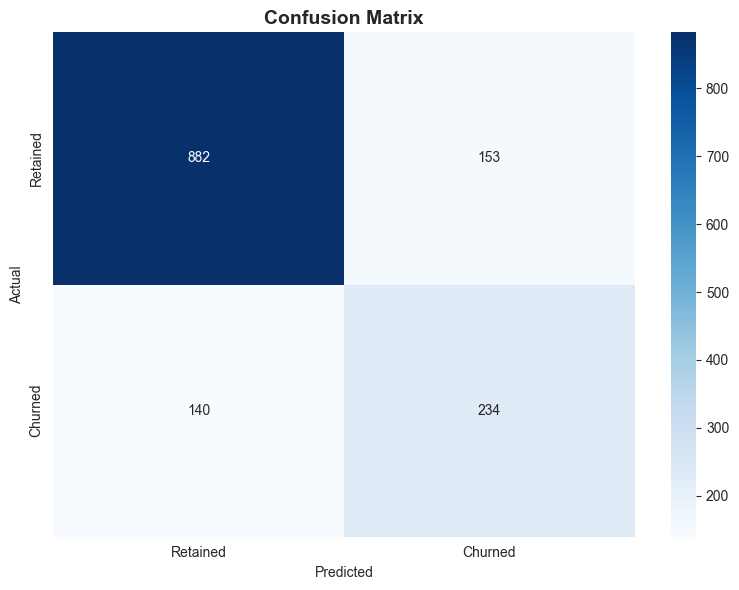


Accuracy: 79.21%
Precision: 60.47%
Recall: 62.57%


In [5]:
cm = metrics['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"\nAccuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")

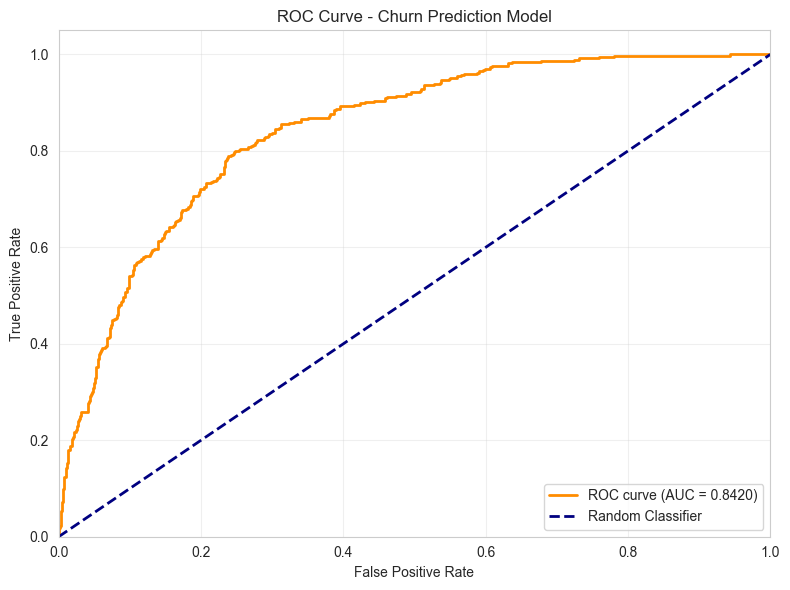

In [6]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(results['y_test'], results['y_pred_proba'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Churn Prediction Model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
feature_importance = predictor.get_feature_importance(X, top_n=20)


Top 20 Features:
  Contract                       0.1171
  tenure                         0.0890
  bonga_points                   0.0770
  MonthlyCharges                 0.0729
  TotalCharges                   0.0677
  TechSupport                    0.0526
  OnlineSecurity                 0.0485
  days_since_bonga_redemption    0.0417
  digital_loyalty_score          0.0397
  avg_monthly_data_gb            0.0391
  customer_engagement_score      0.0344
  InternetService                0.0312
  mpesa_usage_score              0.0299
  mpesa_monthly_transactions     0.0252
  PaymentMethod                  0.0228
  county                         0.0221
  OnlineBackup                   0.0212
  network_quality_score          0.0177
  data_bundle_tier               0.0149
  PaperlessBilling               0.0135


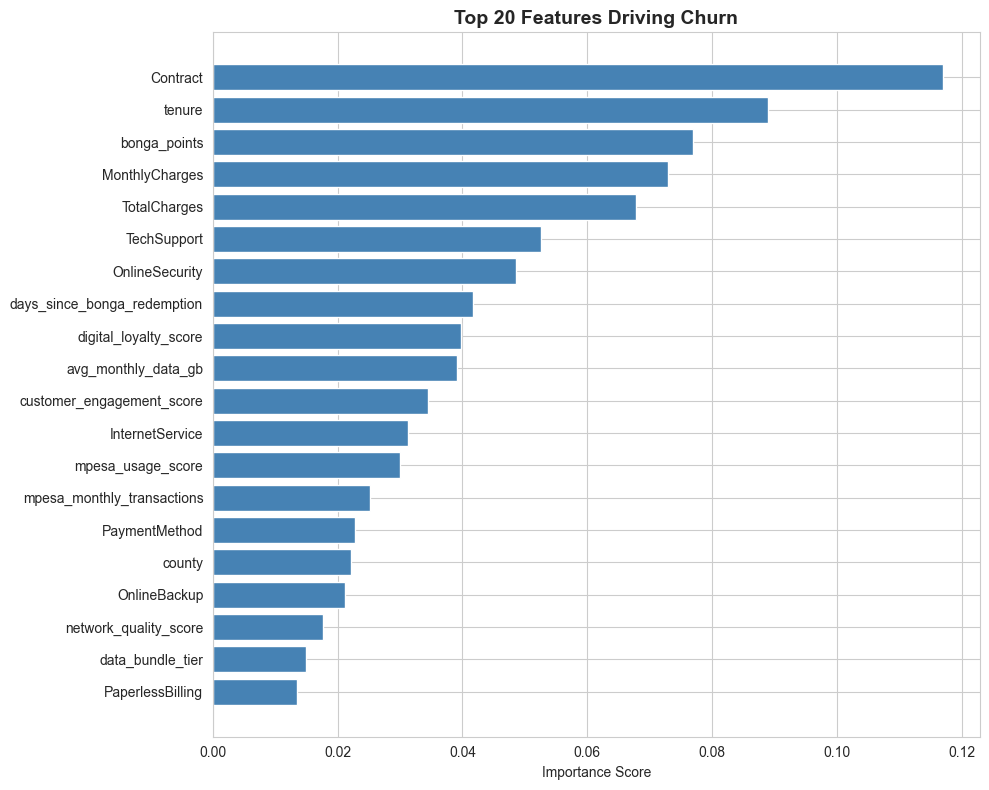

In [8]:
top_features = feature_importance.head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title('Top 20 Features Driving Churn', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

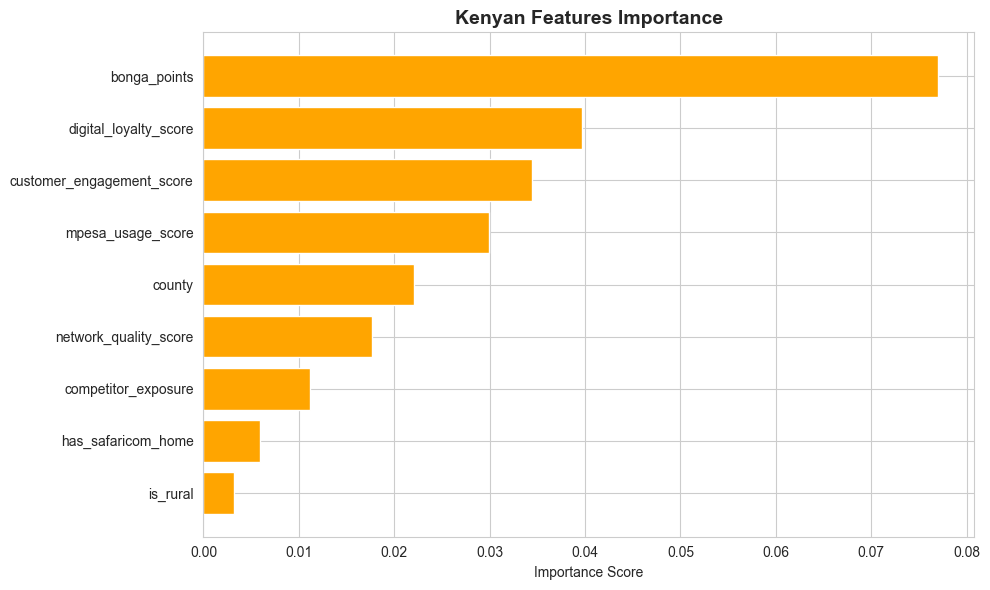


Kenyan features in top 20: 9


In [ ]:
kenyan_features = [
    'mpesa_usage_score', 'bonga_points', 'customer_engagement_score',
    'has_safaricom_home', 'network_quality_score', 'competitor_exposure',
    'digital_loyalty_score', 'is_rural', 'county'
]

kenyan_importance = feature_importance[
    feature_importance['feature'].isin(kenyan_features)
].sort_values('importance', ascending=False)

if len(kenyan_importance) > 0:
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(kenyan_importance)), kenyan_importance['importance'], color='orange')
    plt.yticks(range(len(kenyan_importance)), kenyan_importance['feature'])
    plt.xlabel('Importance Score')
    plt.title('Kenyan Features Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"\nKenyan features in top 20: {len(kenyan_importance)}")
else:
    print("No Kenyan features in encoded form.")

In [10]:

y_test = results['y_test']
y_pred_proba = results['y_pred_proba']


results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Churn_Probability': y_pred_proba,
    'Predicted': (y_pred_proba > 0.5).astype(int)
})


print("High-Risk Customers (>70% churn probability):")
high_risk = results_df[results_df['Churn_Probability'] > 0.7].sort_values('Churn_Probability', ascending=False)
print(high_risk.head(10))

print(f"\nTotal high-risk customers: {len(high_risk)}")

High-Risk Customers (>70% churn probability):
      Actual  Churn_Probability  Predicted
38         1           0.937731          1
1090       1           0.932583          1
341        1           0.924285          1
788        1           0.920546          1
618        1           0.920544          1
746        0           0.913554          1
1109       1           0.910375          1
627        1           0.907315          1
995        0           0.905933          1
278        1           0.904185          1

Total high-risk customers: 163


In [11]:
predictor.save_model()
print("Model saved successfully")

[2026-02-20 21:33:46,396] INFO: Model saved: models/churn_model.pkl


Model saved successfully
